In [1]:
%%capture
!pip install pytorch-tabnet
!pip install optuna

In [2]:
import numpy as np
import pandas as pd
import torch
import tensorflow as tf
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.utils import shuffle


import optuna
from optuna import Trial, visualization

In [3]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_df = pd.read_csv('/kaggle/input/wids-2023/train_data.csv')
test_df = pd.read_csv("/kaggle/input/wids-2023/test_data.csv")
sample = pd.read_csv('/kaggle/input/wids-2023/sample_solution.csv')

print(f"train_shape:{train_df.shape},test_shape:{test_df.shape},Sample_shape:{sample.shape}")

train_shape:(375734, 246),test_shape:(31354, 245),Sample_shape:(31354, 2)


In [6]:
# Explore how the datatypes look like for all the columns
count=0
for feature in list(train_df.columns):
    
    if train_df[feature].dtype == 'float64':
        count +=1
    else:
        print(feature,train_df[feature].dtype)
print(count)
        

index int64
startdate object
climateregions__climateregion object
mjo1d__phase int64
mei__meirank int64
mei__nip int64
240


In [7]:
# Check out for missing values in training data
all_features_nan =  train_df.columns[train_df.isna().any()].tolist()


for feature in all_features_nan:
    print(feature,train_df[feature].isna().sum())

nmme0-tmp2m-34w__ccsm30 15934
nmme-tmp2m-56w__ccsm3 10280
nmme-prate-34w__ccsm3 8738
nmme0-prate-56w__ccsm30 15934
nmme0-prate-34w__ccsm30 15934
nmme-prate-56w__ccsm3 10280
nmme-tmp2m-34w__ccsm3 8738
ccsm30 15934


In [8]:
# Range of dates in training and test dataset
train_df['startdate'] = pd.to_datetime(train_df['startdate'])
test_df['startdate'] = pd.to_datetime(test_df['startdate'])
print(train_df['startdate'].min(),train_df['startdate'].max())
print(test_df['startdate'].min(),test_df['startdate'].max())

2014-09-01 00:00:00 2016-08-31 00:00:00
2022-11-01 00:00:00 2022-12-31 00:00:00


In [9]:
# Group places together by latitude and longtitude
train_df.groupby(['lat','lon']).size()

lat       lon     
0.000000  0.833333    731
          0.866667    731
0.045455  0.833333    731
          0.866667    731
          0.900000    731
                     ... 
1.000000  0.733333    731
          0.766667    731
          0.800000    731
          0.833333    731
          0.866667    731
Length: 514, dtype: int64

In [10]:
test_df.groupby(['lat','lon']).ngroup()

0          0
1          0
2          0
3          0
4          0
        ... 
31349    513
31350    513
31351    513
31352    513
31353    513
Length: 31354, dtype: int64

In [11]:
# Imputing Missing values
imputer = SimpleImputer(strategy='mean')
for feature in all_features_nan:
    train_df[feature] = imputer.fit_transform(train_df[[feature]]).ravel()

In [12]:
# Round off the latitude and longitude till the 14th place
train_df.loc[:,'lat']=round(train_df.lat,14)
train_df.loc[:,'lon']=round(train_df.lon,14)
test_df.loc[:,'lat']=round(test_df.lat,14)
test_df.loc[:,'lon']=round(test_df.lon,14)

In [13]:
# transform non-numerical labels  to numerical labels.
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])


In [14]:
# Replace latitude and lontitude info with 514 unique locations
train_df['unique_loc'] = train_df.groupby(['lat','lon']).ngroup()
test_df['unique_loc'] = test_df.groupby(['lat','lon']).ngroup()

#df_grp=df.groupby(['lat', 'lon', pd.Grouper(key='start_date', freq="W")]).mean()
#df_grp=df_grp.reset_index()

In [15]:
# Replace start date with year, month and day
train_df['year'] = train_df['startdate'].dt.year
train_df['month'] = train_df['startdate'].dt.month
train_df['day_of_year'] = train_df['startdate'].dt.dayofyear

test_df['year'] = test_df['startdate'].dt.year
test_df['month'] = test_df['startdate'].dt.month
test_df['day_of_year'] = test_df['startdate'].dt.dayofyear

In [16]:
# def add_season(df):
#   month_to_season = {
#       1: 0,
#       2: 0,
#       3: 1,
#       4: 1,
#       5: 1,
#       6: 2,
#       7: 2,
#       8: 2, 
#       9: 3, 
#       10: 3,
#       11: 3,
#       12: 0
#   }
#   df['season'] = df['month'].apply(lambda x: month_to_season[x])

# add_season(train_df)
# add_season(test_df)

In [17]:
# from sklearn.preprocessing import FunctionTransformer

# def sin_transformer(period):
#     return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


# def cos_transformer(period):
#     return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [18]:
# def encode_cyclical(df):
#   # encode the day with a period of 365
#   df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['day_of_year'])
#   df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['day_of_year'])

#   # encode the month with a period of 12
#   df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
#   df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

#   # encode the season with a period of 4
#   df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
#   df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

# encode_cyclical(train_df)
# encode_cyclical(test_df)

In [19]:
# Drop uncessary columns including the target column
drop_cols = ['index', 'startdate', 'lat', 'lon']
target = train_df['contest-tmp2m-14d__tmp2m']

target_mean = target.mean().item()
target_std = target.std().item()

target = (target - target_mean)/target_std


train_df = train_df.drop(columns=drop_cols)
train_df = train_df.drop(columns=['contest-tmp2m-14d__tmp2m'])
test_df = test_df.drop(columns=drop_cols)

In [20]:
corr_test = test_df.corr().abs()

In [21]:
upper_tri_test = corr_test.where(np.triu(np.ones(corr_test.shape),k=1).astype(np.bool))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [22]:
to_drop_test = [column for column in upper_tri_test.columns if any(upper_tri_test[column] > 0.95)]

In [23]:
train_df = train_df.drop(columns=to_drop_test)
test_df = test_df.drop(columns=to_drop_test)

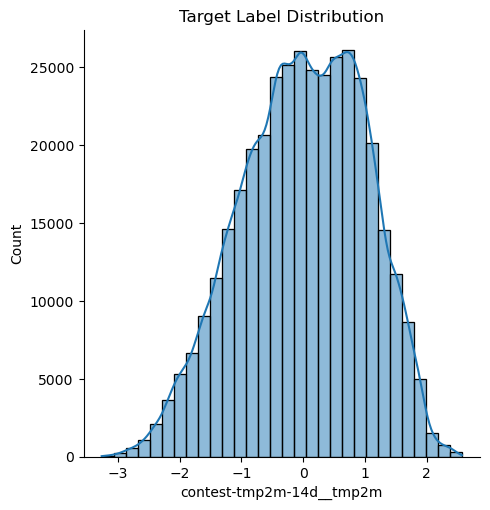

In [24]:
import matplotlib.pyplot as plt
sns.displot(data=target, bins=30, kind='hist', kde=True,).set(title='Target Label Distribution')
plt.show()

In [25]:
train_df.shape

(375734, 180)

In [26]:
features = train_df.columns 
cat_cols = ["year","unique_loc","climateregions__climateregion"]
cont_cols = [column for column in features if column not in cat_cols]

In [27]:
for column in cont_cols:
    mean = train_df[column].mean().item()
    std = train_df[column].std().item()

    train_df[column] = (train_df[column] - mean)/std
    test_df[column] = (test_df[column] - mean)/std

In [28]:
features = train_df.columns
X = train_df[features].values
Y = target.to_numpy().reshape(-1,1)


X_test = test_df[features].values

In [29]:
np.any(np.isnan(X))

False

In [30]:
np.all(np.isfinite(X))

True

In [60]:
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da",64, 256, step=4)
    
    n_steps = trial.suggest_int("n_steps", 1, 5, step=1)
    n_independent = trial.suggest_int("n_independent", 1, 5, step=1)
    gamma = trial.suggest_float("gamma", 1., 3.0, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 5)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,n_independent= n_independent,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
        regressor = TabNetRegressor(**tabnet_params,device_name=DEVICE)
        regressor.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100),
                  eval_metric=['rmse'])
        CV_score_array.append(regressor.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [ ]:
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(Objective,n_trials=3,timeout=5*60) #5 hours

[I 2023-02-25 10:38:19,375] A new study created in memory with name: TabNet optimization


Stop training because you reached max_epochs = 23 with best_epoch = 15 and best_val_0_rmse = 0.10925


/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 23 with best_epoch = 11 and best_val_0_rmse = 0.09934


/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 23 with best_epoch = 19 and best_val_0_rmse = 0.11575


/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [34]:
# kf = KFold(n_splits=10, random_state=42, shuffle=True)
# predictions_array =[]
# CV_score_array    =[]
# for train_index, test_index in kf.split(X):
#     X_train, X_valid = X[train_index], X[test_index]
#     y_train, y_valid = Y[train_index], Y[test_index]
#     regressor = TabNetRegressor(verbose=1,seed=42,device_name=DEVICE,optimizer_params=dict(lr=1e-3))
#     regressor.fit(X_train=X_train, y_train=y_train,
#               eval_set=[(X_valid, y_valid)],
#               patience=15, max_epochs=200,
#               eval_metric=['rmse'])
#     CV_score_array.append(regressor.best_cost)
#     predictions_array.append(regressor.predict(X_test))

# predictions = np.mean(predictions_array,axis=0)

In [35]:
# TabNet_params = study.best_params

In [36]:
TabNet_params =  {'mask_type': 'entmax', 'n_da': 76, 'n_steps': 4, 'n_independent': 2, 'gamma': 2.2, 'n_shared': 4, 'lambda_sparse': 1.6427945044122125e-06, 'patienceScheduler': 7, 'patience': 26, 'epochs': 88}

In [37]:
final_params = dict(n_d=76, n_a=76, n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     n_independent = TabNet_params['n_independent'], lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )
epochs = TabNet_params['epochs']

In [38]:
regressor = TabNetRegressor(**final_params)
regressor.fit(X_train=X, y_train=Y,
          patience=TabNet_params['patience'], max_epochs=epochs,
          eval_metric=['rmse'])#augmentations=aug)

/opt/conda/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [50]:
predictions = regressor.predict(X_test)

## Training to the test set is often a bad idea.

In [56]:
predictions = predictions*target_std+target_mean

In [58]:
predictions = predictions.reshape(31354,)

In [59]:
df = pd.DataFrame()
df['prediction_label'] = predictions.tolist()
df.to_csv('sub_1.csv')

In [48]:
# save tabnet model
saving_path_name = "/kaggle/working/tabnet_model_best"
saved_filepath = regressor.save_model(saving_path_name)

Successfully saved model at /kaggle/working/tabnet_model_best.zip


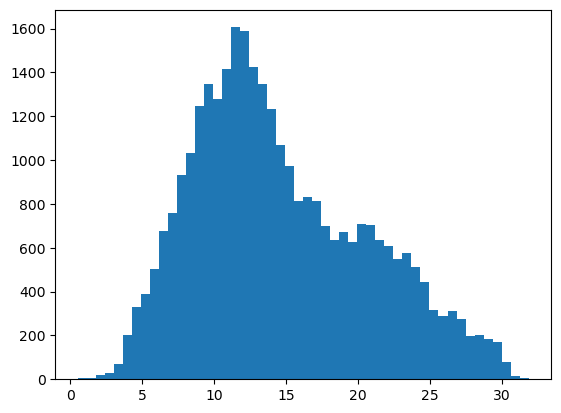

In [57]:
import matplotlib.pyplot as plt
plt.hist(predictions, bins=50)
#plt.hist(unseen_predictions_1['prediction_label'], bins=50)
plt.show()